# What is it?
spyIVP is in principle YET ANOTHER(!!) a general(ish)-purpose nnumerical IVP solver with some symbollic elements. It has a lot of overlap with Mathematica's NDSolve- NDSolve obviously is way more powerful for solving general equations (including PDEs).  But symODE is good for a range of useful problems, and has (or will have) a few features that aren't easily reproduced in Mathematics.  Overall it is less of a 'black-box' than NDSolve, for better or worse.

1. Can easily add explicit numerical code ( can in Mathematica too, but more hoops)
2. Can (shortly) integrate with tensorflow, bot for increased speed and to enable automatic differentiation.
3. The driving use case is ensembles of similar atoms interacting by long-range electric fields: large ensembles of states with long-range coupling

Other python ODE solving packages that are likely more approtriate for general use:

* https://github.com/neurophysik/jitcode,
* http://bjodah.github.io/pyodesys/latest/index.html

They both seem more powerful, could likely replace this package for even the desired purpose. However I only learned about them after writing this, and I haven't tried them. To my mind it does seem unlikely that they'll be easily extended to large scales or to automatic differentiation of the whole system as is possible with Tensorflow, but please let me know if I"m mistaken


# Some examples

Mostly what it's written for though is to enable assembling/solving master-equation based systems in python. That will be covered in [Solving master equations using pySODE]




## Imports

In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *
from spylind import spyIVP as so
import sympy as sm
sm.init_printing()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Projectile motion

$$\frac{dx}{dt} = vx$$
$$\frac{dy}{dt} = vy$$

$$\frac{dv_x}{dt} = g$$
$$\frac{dv_y}{dt} = 0$$

In [25]:
xS, yS, vxS, vyS = sm.symbols("x, y, v_x, v_y", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS,
       vxS:0,
       vyS:g }

Munch({'tSym': t, 'dimSyms': [], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': []})
state dependent functions should have signature [t, x, y, v_x, v_y]
Not integrating first step (it's just the initial state)


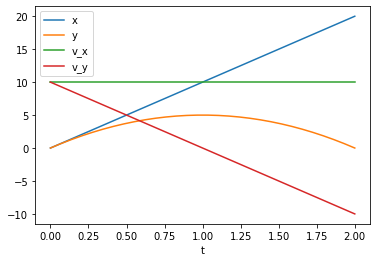

In [26]:
ode_s = so.ODESolver(dy_dtD,  dims={})
ode_s.set_initial_conditions({xS:0,yS:0,vxS:10,vyS:10}) 
ode_s.setup()
tSteps = linspace(0,2,30)
arr =ode_s.integrate(tSteps, 1.0)

sm.ode
plot(tSteps, arr.real)
xlabel('t')
legend(dy_dtD.keys())

In [27]:
tEff = tSteps #+ (tSteps[1]-tSteps[0])/2
sym_res = dict(
    x= 10 *tEff,
    y = 10*tEff -5*tEff**2
    )
allclose(arr[:,0], sym_res['x'])
allclose(arr[:,1], sym_res['y'])

True

In [90]:
tS = sm.symbols("t")

xS = sm.Function('x')(tS)
vxS = sm.Function('v_x')(tS)
yS = sm.Function('y')(tS)
vyS = sm.Function('v_y')(tS)





In [102]:
from sympy import ode
sm.dsolve([sm.Eq(xS.diff(), vxS), sm.Eq(vxS.diff(), 0)])
eqL = [sm.Eq(yS.diff(),vyS), sm.Eq(vyS.diff(), g)]
sm.dsolve(sm.Eq(yS.diff(), g*tS) )

## An ensemble of similar projectiles

Munch({'tSym': t, 'dimSyms': [z], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': [z]})
state dependent functions should have signature [t, z, x, y, v_x, v_y]


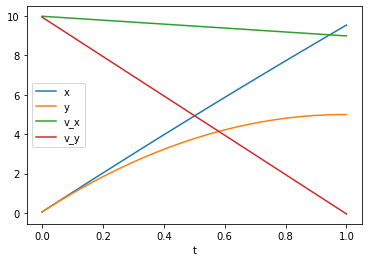

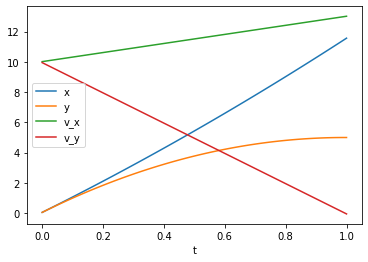

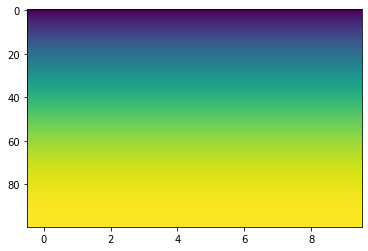

In [6]:
xS, yS, vxS, vyS = sm.symbols("x, y, v_x, v_y", real=True)
zS = sm.symbols("z", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS ,
       vxS:1 +zS,
       vyS: g  }

ode_s = so.ODESolver(dy_dtD,  dims={zS:linspace(-2,2,10)})
ode_s.set_initial_conditions({xS:0,yS:0,vxS:10,vyS:10}) 
ode_s.setup(bForceStateDimensions=True)
tSteps = linspace(0,1,100)
arr =ode_s.integrate(tSteps, 1.0)

plot(tSteps, arr[:,:,0].real)
xlabel('t')
legend(dy_dtD.keys())
figure()
plot(tSteps, arr[:,:,-1].real)
xlabel('t')
legend(dy_dtD.keys())
figure()
imshow(arr[:,1,:].real, aspect='auto')

## An ensemble of interacting projectiles (via a mutual attraction)

What happens if the projectiles experience a force pushing toward their center-of-mass.

Currently there's no easy way to decsribe the interaction symbollically (though may yet be added). It's easy to do numerically however.

The interaction is $F_j = \sum_{i\neq j}^n k \frac{y_i-y_j}{|(y_i-y_j)^3|}$. This is infinite as particles get close, which is obviously a problem for a simulation. So we'll need to damp it at close range.



Munch({'tSym': t, 'dimSyms': [ind], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': [k]})
state dependent functions should have signature [t, ind, x, y, v_x, v_y]


Text(0.5, 1.0, 'mutually attractive projectiles')

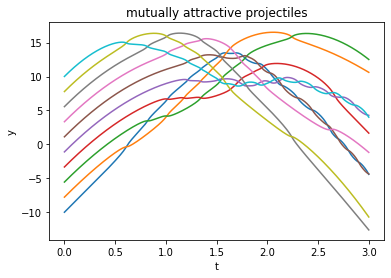

In [39]:
xS, yS, vxS, vyS, kS = sm.symbols("x, y, v_x, v_y, k", real=True)
indS = sm.symbols("ind", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS,
       vxS:1,
       vyS: g + 30*kS }

ode_s = so.ODESolver(dy_dtD,  dims={indS:arange(10)})
ode_s.set_initial_conditions({xS:0*ones(10),yS:linspace(-10,10,10),vxS:10*ones(10),vyS:15*ones(10) }) 
def couplingF(t, dimAxes, state, driving_vals):
    x,y,vx,vy = state
    diff = y[:,newaxis] - y[newaxis,:]
    diff[np.diag_indices_from(diff)]=1e20 # Stop divide by zeros due to distance of particles from themselves
    sq_diff = diff**2 / (1- exp(-(diff/0.3)**2 ))#  Need to damp the interaction for close particles to avoid singularities
    #sq_diff[np.diag_indices_from(sq_diff)]=1. 
    F = -np.sum(sign(diff)/sq_diff, axis=1)
    return F
ode_s.set_state_dep_funcs({kS:couplingF})

ode_s.setup(bForceStateDimensions=True)
tSteps = linspace(0,3.,2000)
arr =ode_s.integrate(tSteps, 1.0)

plot(tSteps, arr[:,1,:].real)
xlabel('t')
ylabel('y')
title("mutually attractive projectiles")



## Using a custom output function

Munch({'tSym': t, 'dimSyms': [ind], 'prop_state_syms': [x, y, v_x, v_y], 'stationary_state_syms': [], 'driving_syms': [], 'state_dep_syms': [k]})
state dependent functions should have signature [t, ind, x, y, v_x, v_y]


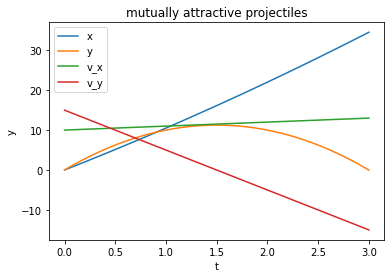

In [16]:
xS, yS, vxS, vyS, kS = sm.symbols("x, y, v_x, v_y, k", real=True)
indS = sm.symbols("ind", real=True)
g= -10.0
dy_dtD = {xS:vxS, 
       yS:vyS,
       vxS:1,
       vyS: g + 30*kS }

ode_s = so.ODESolver(dy_dtD,  dims={indS:arange(10)})
ode_s.set_initial_conditions({xS:0*ones(10),yS:linspace(-10,10,10),vxS:10*ones(10),vyS:15*ones(10) }) 
def couplingF(t, dimAxes, state, driving_vals):
    x,y,vx,vy = state
    diff = y[:,newaxis] - y[newaxis,:]
    diff[np.diag_indices_from(diff)]=1e20 # Stop divide by zeros due to distance of particles from themselves
    sq_diff = diff**2 / (1- exp(-(diff/0.3)**2 ))#  Need to damp the interaction for close particles to avoid singularities
    #sq_diff[np.diag_indices_from(sq_diff)]=1. 
    F = -np.sum(sign(diff)/sq_diff, axis=1)
    return F
ode_s.set_state_dep_funcs({kS:couplingF})

def output_mean_state(state):
    mean_state = state.mean(axis=1)
    return mean_state
ode_s.set_online_processing(output_mean_state)


ode_s.setup(bForceStateDimensions=True)
tSteps = linspace(0,3.,2000)
arr =ode_s.integrate(tSteps, 1.0)

plot(tSteps, arr[:,:].real)
xlabel('t')
ylabel('y')
title("mutually attractive projectiles")
legend(ode_s.symsD.prop_state_syms)

